# Hess-MC² Scaling Laws

Benchmark wall-clock time of `fit(..., method="hessmc2")` as model complexity grows.

**Primary axes**: `D` (parameter dimension, driven by `n_latent`) and `T` (time series length).

**Secondary axes**: `N` (SMC particles), `K` (iterations), `N_PF` (PF particles), proposal type.

| Symbol | Meaning | Baseline | Sweep |
|--------|---------|----------|-------|
| `n_latent` | Latent processes → D | 2 | 1→6 |
| `T` | Time points | 40 | 10→300 |
| `N` | SMC particles | 8 | 4→64 |
| `K` | SMC iterations | 3 | 2→20 |
| `N_PF` | PF particles | 50 | 25→400 |
| proposal | RW / MALA / Hessian | mala | all three |

In [ ]:
from __future__ import annotations

import time
from dataclasses import dataclass

import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy.linalg as jla
import matplotlib.pyplot as plt
import numpy as np

from causal_ssm_agent.orchestrator.schemas_model import DistributionFamily
from causal_ssm_agent.models.ssm import SSMModel, SSMPriors, SSMSpec, discretize_system, fit

print(f"JAX {jax.__version__}  backend={jax.default_backend()}  devices={jax.devices()}")

## DGP factory

Generates a synthetic dataset and model of arbitrary size.

In [ ]:
@dataclass
class BenchmarkProblem:
    """Everything needed to call fit()."""
    model: SSMModel
    obs: jnp.ndarray
    times: jnp.ndarray
    D: int  # parameter dimension (computed after first trace)


def make_problem(
    n_latent: int = 2,
    n_manifest: int | None = None,
    T: int = 40,
    dt: float = 0.5,
    n_pf: int = 50,
    seed: int = 42,
) -> BenchmarkProblem:
    """Create a Poisson-observed SSM of given size and simulate data."""
    if n_manifest is None:
        n_manifest = n_latent + 2  # always have some free loadings

    key = random.PRNGKey(seed)
    n = n_latent

    # --- Stable drift: diagonal dominant ---
    key, dk = random.split(key)
    offdiag = 0.1 * random.normal(dk, (n, n))
    true_drift = offdiag.at[jnp.diag_indices(n)].set(
        -jnp.abs(0.5 + 0.3 * random.normal(dk, (n,)))
    )

    true_diff_diag = 0.2 + 0.1 * jnp.abs(random.normal(key, (n,)))
    true_cint = 0.2 * random.normal(key, (n,))

    # Lambda: identity block on top, random loadings below
    lam_top = jnp.eye(n_manifest, n)  # first min(n_manifest, n) rows are identity
    if n_manifest > n:
        key, lk = random.split(key)
        extra = 0.5 * random.normal(lk, (n_manifest - n, n))
        lam_top = lam_top.at[n:, :].set(extra)
    true_lambda = lam_top

    log_baselines = jnp.log(3.0 + 2.0 * jnp.abs(random.normal(key, (n_manifest,))))

    # --- Simulate ---
    diff_cov = jnp.diag(true_diff_diag ** 2)
    Ad, Qd, cd = discretize_system(true_drift, diff_cov, true_cint, dt)
    Qd_chol = jla.cholesky(Qd + jnp.eye(n) * 1e-8, lower=True)

    key, ik = random.split(key)
    x = jla.cholesky(jnp.eye(n) * 0.3, lower=True) @ random.normal(ik, (n,))
    states = [x]
    for _ in range(T - 1):
        key, nk = random.split(key)
        x = Ad @ x + cd.flatten() + Qd_chol @ random.normal(nk, (n,))
        states.append(x)
    latent = jnp.stack(states)

    # Poisson observations
    rates = jnp.exp(jax.vmap(lambda s: true_lambda @ s + log_baselines)(latent))
    key, ok = random.split(key)
    obs = random.poisson(ok, rates).astype(float)
    times = jnp.arange(T, dtype=float) * dt

    # --- Model spec ---
    spec = SSMSpec(
        n_latent=n_latent,
        n_manifest=n_manifest,
        drift="free",
        diffusion="diag",
        cint="free",
        lambda_mat="free",
        manifest_means="free",
        manifest_var="diag",
        t0_means="free",
        t0_var="diag",
        manifest_dist=DistributionFamily.POISSON,
    )
    priors = SSMPriors(
        drift_diag={"mu": -0.5, "sigma": 0.5},
        drift_offdiag={"mu": 0.0, "sigma": 0.3},
        diffusion_diag={"sigma": 0.5},
        cint={"mu": 0.0, "sigma": 0.5},
        lambda_free={"mu": 0.5, "sigma": 0.5},
        manifest_means={"mu": 0.0, "sigma": 2.0},
        manifest_var_diag={"sigma": 0.5},
    )
    model = SSMModel(spec, priors=priors, n_particles=n_pf, pf_seed=seed)

    # Compute D by tracing once
    from jax.flatten_util import ravel_pytree
    from numpyro import handlers
    import numpyro.distributions as dist

    with handlers.seed(rng_seed=seed):
        trace = handlers.trace(model.model).get_trace(obs, times, None)
    unc = {}
    for name, site in trace.items():
        if site["type"] == "sample" and not site.get("is_observed", False) and name != "log_likelihood":
            t = dist.transforms.biject_to(site["fn"].support)
            unc[name] = t.inv(site["value"])
    D = ravel_pytree(unc)[0].shape[0]

    return BenchmarkProblem(model=model, obs=obs, times=times, D=D)

## Timing harness

In [3]:
def bench(
    problem: BenchmarkProblem,
    N: int = 8,
    K: int = 3,
    proposal: str = "mala",
    step_size: float = 0.01,
    warmup: bool = True,
) -> float:
    """Time a single fit() call. Returns wall-clock seconds.

    If warmup=True, does one throwaway run first to JIT-compile.
    """
    kw = dict(
        observations=problem.obs,
        times=problem.times,
        method="hessmc2",
        n_smc_particles=N,
        n_iterations=K,
        proposal=proposal,
        step_size=step_size,
        seed=0,
    )
    if warmup:
        # Warmup run to trigger JIT compilation
        fit(problem.model, **{**kw, "n_smc_particles": 2, "n_iterations": 1})

    jax.block_until_ready(problem.obs)  # sync
    t0 = time.perf_counter()
    result = fit(problem.model, **kw)
    # Force all computation to finish
    jax.block_until_ready(result.get_samples()[list(result.get_samples().keys())[0]])
    return time.perf_counter() - t0

## Plotting helper

In [4]:
def plot_scaling(xs, ys, xlabel, title, labels=None, log_x=False, log_y=True, fit_power=True):
    """Plot scaling curve with optional power-law fit."""
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))

    if labels is None:
        # Single series
        ax.plot(xs, ys, "o-", linewidth=2, markersize=6)
        if fit_power and len(xs) >= 3:
            lx, ly = np.log(np.array(xs, dtype=float)), np.log(np.array(ys, dtype=float))
            slope, intercept = np.polyfit(lx, ly, 1)
            xs_fit = np.linspace(min(xs), max(xs), 50)
            ys_fit = np.exp(intercept) * xs_fit ** slope
            ax.plot(xs_fit, ys_fit, "--", alpha=0.5, color="gray",
                    label=f"~{xlabel}^{slope:.2f}")
            ax.legend(fontsize=11)
    else:
        # Multiple series
        for y, lbl in zip(ys, labels):
            ax.plot(xs, y, "o-", linewidth=2, markersize=6, label=lbl)
        ax.legend(fontsize=11)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("Wall-clock time (s)", fontsize=12)
    ax.set_title(title, fontsize=13)
    if log_x:
        ax.set_xscale("log")
    if log_y:
        ax.set_yscale("log")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    return fig

---
## 1. Scaling with `n_latent` (model complexity → D)

This drives the parameter dimension D quadratically (drift has n² entries).

Hess-MC²: N=2, K=1, D=13, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=13, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=4.0/8 [resampled]
  step 3/3  ESS=5.1/8


  n_latent=1  D= 13  time=5.83s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=2.0/8 [resampled]
  step 3/3  ESS=2.6/8 [resampled]


  n_latent=2  D= 24  time=5.33s


Hess-MC²: N=2, K=1, D=37, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=37, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.2/8 [resampled]


  n_latent=3  D= 37  time=5.86s


Hess-MC²: N=2, K=1, D=52, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=52, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.5/8 [resampled]
  step 3/3  ESS=1.6/8 [resampled]


  n_latent=4  D= 52  time=6.76s


Hess-MC²: N=2, K=1, D=69, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=69, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.0/8 [resampled]


  n_latent=5  D= 69  time=7.13s


Hess-MC²: N=2, K=1, D=88, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=88, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.0/8 [resampled]


  n_latent=6  D= 88  time=7.43s


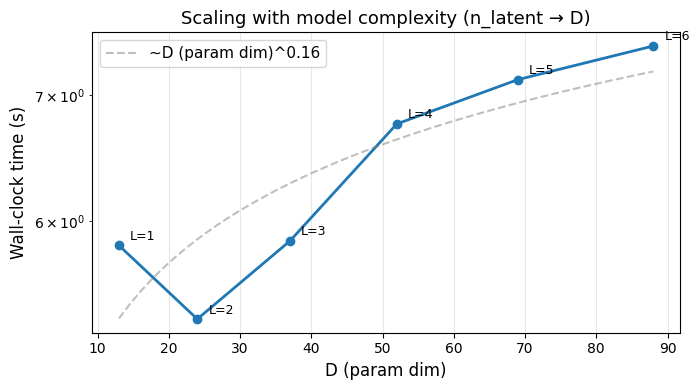

In [5]:
latent_sizes = [1, 2, 3, 4, 5, 6]
times_lat, dims_lat = [], []

for nl in latent_sizes:
    p = make_problem(n_latent=nl, T=40, n_pf=50)
    t = bench(p, N=8, K=3, proposal="mala")
    times_lat.append(t)
    dims_lat.append(p.D)
    print(f"  n_latent={nl}  D={p.D:>3d}  time={t:.2f}s")

fig = plot_scaling(dims_lat, times_lat, "D (param dim)",
                   "Scaling with model complexity (n_latent → D)")
ax = fig.axes[0]
for nl, d, t in zip(latent_sizes, dims_lat, times_lat):
    ax.annotate(f"L={nl}", (d, t), textcoords="offset points",
                xytext=(8, 4), fontsize=9)

## 2. Scaling with `T` (time series length)

Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=3.7/8 [resampled]


  step 3/3  ESS=6.0/8


  T=  10  time=5.38s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=4.0/8 [resampled]


  step 3/3  ESS=5.3/8


  T=  20  time=6.35s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=2.0/8 [resampled]
  step 3/3  ESS=2.6/8 [resampled]


  T=  40  time=5.22s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.1/8 [resampled]
  step 3/3  ESS=1.1/8 [resampled]


  T=  80  time=5.23s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=2.6/8 [resampled]
  step 3/3  ESS=2.6/8 [resampled]


  T= 120  time=4.99s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.1/8 [resampled]
  step 3/3  ESS=1.4/8 [resampled]


  T= 200  time=5.56s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.0/8 [resampled]


  T= 300  time=4.88s


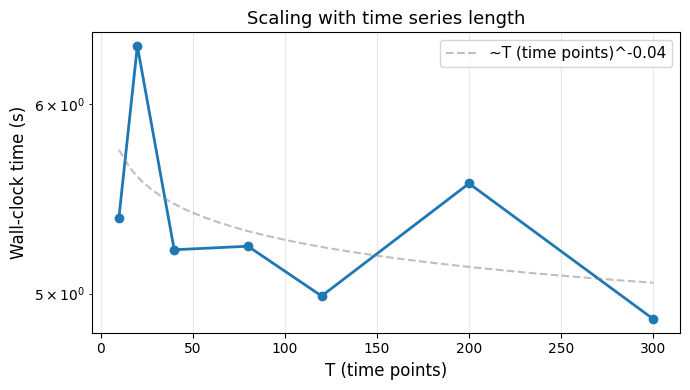

In [6]:
T_values = [10, 20, 40, 80, 120, 200, 300]
times_T = []

for T in T_values:
    p = make_problem(n_latent=2, T=T, n_pf=50)
    t = bench(p, N=8, K=3, proposal="mala")
    times_T.append(t)
    print(f"  T={T:>4d}  time={t:.2f}s")

plot_scaling(T_values, times_T, "T (time points)",
             "Scaling with time series length");

## 2b. D × T heatmap

Joint scaling — this is the realistic knob space.

Hess-MC²: N=2, K=1, D=13, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.1/2


Hess-MC²: N=8, K=3, D=13, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=7.0/8
  step 3/3  ESS=6.9/8


  L=1 D= 13 T=  20  5.03s


Hess-MC²: N=2, K=1, D=13, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=13, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=4.0/8 [resampled]
  step 3/3  ESS=5.1/8


  L=1 D= 13 T=  40  4.66s


Hess-MC²: N=2, K=1, D=13, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=13, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=3.6/8 [resampled]
  step 3/3  ESS=1.7/8 [resampled]


  L=1 D= 13 T=  80  4.83s


Hess-MC²: N=2, K=1, D=13, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=13, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.6/8 [resampled]


  L=1 D= 13 T= 160  5.00s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=4.0/8 [resampled]


  step 3/3  ESS=5.3/8


  L=2 D= 24 T=  20  5.72s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=2.0/8 [resampled]
  step 3/3  ESS=2.6/8 [resampled]


  L=2 D= 24 T=  40  5.36s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.1/8 [resampled]
  step 3/3  ESS=1.1/8 [resampled]


  L=2 D= 24 T=  80  5.97s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.5/8 [resampled]
  step 3/3  ESS=2.0/8 [resampled]


  L=2 D= 24 T= 160  5.46s


Hess-MC²: N=2, K=1, D=37, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=37, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=2.3/8 [resampled]
  step 3/3  ESS=2.4/8 [resampled]


  L=3 D= 37 T=  20  6.05s


Hess-MC²: N=2, K=1, D=37, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=37, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.2/8 [resampled]


  L=3 D= 37 T=  40  5.76s


Hess-MC²: N=2, K=1, D=37, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=37, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.4/8 [resampled]
  step 3/3  ESS=1.0/8 [resampled]


  L=3 D= 37 T=  80  6.06s


Hess-MC²: N=2, K=1, D=37, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=37, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.3/8 [resampled]


  L=3 D= 37 T= 160  5.68s


Hess-MC²: N=2, K=1, D=52, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=52, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.0/8 [resampled]


  L=4 D= 52 T=  20  5.85s


Hess-MC²: N=2, K=1, D=52, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=52, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.5/8 [resampled]
  step 3/3  ESS=1.6/8 [resampled]


  L=4 D= 52 T=  40  5.95s


Hess-MC²: N=2, K=1, D=52, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=52, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=2.2/8 [resampled]


  L=4 D= 52 T=  80  5.43s


Hess-MC²: N=2, K=1, D=52, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=52, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=0.1/8 [resampled]
  step 3/3  ESS=8.0/8


  L=4 D= 52 T= 160  5.64s


Hess-MC²: N=2, K=1, D=69, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=69, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.2/8 [resampled]


  L=5 D= 69 T=  20  6.39s


Hess-MC²: N=2, K=1, D=69, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=69, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.0/8 [resampled]


  L=5 D= 69 T=  40  6.32s


Hess-MC²: N=2, K=1, D=69, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=69, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.0/8 [resampled]


  L=5 D= 69 T=  80  6.61s


Hess-MC²: N=2, K=1, D=69, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=69, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.0/8 [resampled]


  L=5 D= 69 T= 160  6.93s


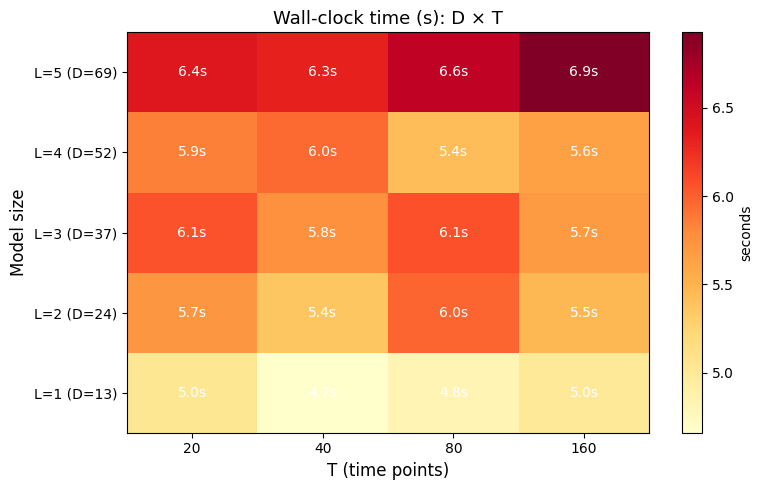

In [7]:
hm_latents = [1, 2, 3, 4, 5]
hm_T = [20, 40, 80, 160]
hm_times = np.zeros((len(hm_latents), len(hm_T)))
hm_dims = []

for i, nl in enumerate(hm_latents):
    for j, T in enumerate(hm_T):
        p = make_problem(n_latent=nl, T=T, n_pf=50)
        if j == 0:
            hm_dims.append(p.D)
        t = bench(p, N=8, K=3, proposal="mala")
        hm_times[i, j] = t
        print(f"  L={nl} D={p.D:>3d} T={T:>4d}  {t:.2f}s")

fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(hm_times, aspect="auto", origin="lower", cmap="YlOrRd")
ax.set_xticks(range(len(hm_T)))
ax.set_xticklabels([str(t) for t in hm_T])
ax.set_yticks(range(len(hm_latents)))
ax.set_yticklabels([f"L={nl} (D={d})" for nl, d in zip(hm_latents, hm_dims)])
ax.set_xlabel("T (time points)", fontsize=12)
ax.set_ylabel("Model size", fontsize=12)
ax.set_title("Wall-clock time (s): D × T", fontsize=13)

# Annotate cells with timing
for i in range(len(hm_latents)):
    for j in range(len(hm_T)):
        val = hm_times[i, j]
        color = "white" if val > hm_times.max() * 0.6 else "black"
        ax.text(j, i, f"{val:.1f}s", ha="center", va="center", color=color, fontsize=10)

fig.colorbar(im, ax=ax, label="seconds")
fig.tight_layout()

## 3. Scaling with `N` (SMC particles)

Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=4, K=3, D=24, proposal=mala, eps=0.01
  Initializing 4 particles from prior...


  step 1/3  ESS=1.0/4 [resampled]
  step 2/3  ESS=1.5/4 [resampled]
  step 3/3  ESS=1.0/4 [resampled]


  N=  4  time=5.43s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=2.0/8 [resampled]
  step 3/3  ESS=2.6/8 [resampled]


  N=  8  time=5.46s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=16, K=3, D=24, proposal=mala, eps=0.01
  Initializing 16 particles from prior...


  step 1/3  ESS=1.0/16 [resampled]
  step 2/3  ESS=3.5/16 [resampled]
  step 3/3  ESS=1.2/16 [resampled]


  N= 16  time=10.61s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=32, K=3, D=24, proposal=mala, eps=0.01
  Initializing 32 particles from prior...


  step 1/3  ESS=1.0/32 [resampled]
  step 2/3  ESS=1.3/32 [resampled]
  step 3/3  ESS=1.6/32 [resampled]


  N= 32  time=15.04s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=64, K=3, D=24, proposal=mala, eps=0.01
  Initializing 64 particles from prior...


  step 1/3  ESS=1.0/64 [resampled]
  step 2/3  ESS=2.2/64 [resampled]
  step 3/3  ESS=1.7/64 [resampled]


  N= 64  time=27.58s


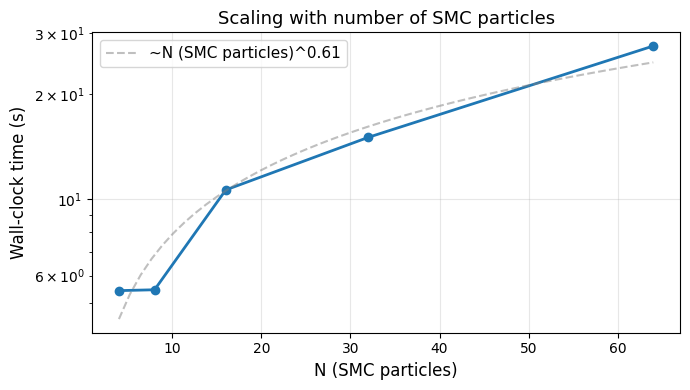

In [8]:
N_values = [4, 8, 16, 32, 64]
times_N = []

p = make_problem(n_latent=2, T=40, n_pf=50)
for N in N_values:
    t = bench(p, N=N, K=3, proposal="mala")
    times_N.append(t)
    print(f"  N={N:>3d}  time={t:.2f}s")

plot_scaling(N_values, times_N, "N (SMC particles)",
             "Scaling with number of SMC particles");

## 4. Scaling with `K` (SMC iterations)

Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=2, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/2  ESS=1.0/8 [resampled]
  step 2/2  ESS=2.0/8 [resampled]


  K=  2  time=5.68s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=5, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/5  ESS=1.0/8 [resampled]
  step 2/5  ESS=2.0/8 [resampled]
  step 3/5  ESS=2.6/8 [resampled]
  step 4/5  ESS=1.4/8 [resampled]
  step 5/5  ESS=3.7/8 [resampled]


  K=  5  time=5.82s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=10, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/10  ESS=1.0/8 [resampled]
  step 2/10  ESS=2.0/8 [resampled]
  step 3/10  ESS=2.6/8 [resampled]
  step 4/10  ESS=1.4/8 [resampled]
  step 5/10  ESS=3.7/8 [resampled]
  step 6/10  ESS=3.1/8 [resampled]
  step 7/10  ESS=3.5/8 [resampled]
  step 8/10  ESS=3.9/8 [resampled]


  step 9/10  ESS=4.0/8
  step 10/10  ESS=1.8/8 [resampled]


  K= 10  time=6.91s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=15, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/15  ESS=1.0/8 [resampled]
  step 2/15  ESS=2.0/8 [resampled]
  step 3/15  ESS=2.6/8 [resampled]
  step 4/15  ESS=1.4/8 [resampled]
  step 5/15  ESS=3.7/8 [resampled]
  step 6/15  ESS=3.1/8 [resampled]
  step 7/15  ESS=3.5/8 [resampled]
  step 8/15  ESS=3.9/8 [resampled]


  step 9/15  ESS=4.0/8
  step 10/15  ESS=1.8/8 [resampled]
  step 11/15  ESS=1.0/8 [resampled]
  step 12/15  ESS=3.9/8 [resampled]
  step 13/15  ESS=1.4/8 [resampled]
  step 14/15  ESS=1.5/8 [resampled]
  step 15/15  ESS=1.4/8 [resampled]


  K= 15  time=5.91s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=20, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/20  ESS=1.0/8 [resampled]
  step 2/20  ESS=2.0/8 [resampled]
  step 3/20  ESS=2.6/8 [resampled]
  step 4/20  ESS=1.4/8 [resampled]
  step 5/20  ESS=3.7/8 [resampled]
  step 6/20  ESS=3.1/8 [resampled]
  step 7/20  ESS=3.5/8 [resampled]
  step 8/20  ESS=3.9/8 [resampled]


  step 9/20  ESS=4.0/8
  step 10/20  ESS=1.8/8 [resampled]
  step 11/20  ESS=1.0/8 [resampled]
  step 12/20  ESS=3.9/8 [resampled]
  step 13/20  ESS=1.4/8 [resampled]
  step 14/20  ESS=1.5/8 [resampled]
  step 15/20  ESS=1.4/8 [resampled]
  step 16/20  ESS=2.5/8 [resampled]
  step 17/20  ESS=1.8/8 [resampled]
  step 18/20  ESS=1.8/8 [resampled]
  step 19/20  ESS=1.0/8 [resampled]
  step 20/20  ESS=1.0/8 [resampled]


  K= 20  time=6.24s


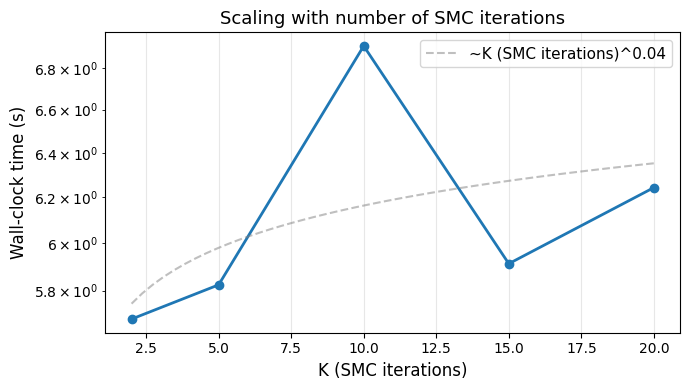

In [9]:
K_values = [2, 5, 10, 15, 20]
times_K = []

p = make_problem(n_latent=2, T=40, n_pf=50)
for K in K_values:
    t = bench(p, N=8, K=K, proposal="mala")
    times_K.append(t)
    print(f"  K={K:>3d}  time={t:.2f}s")

plot_scaling(K_values, times_K, "K (SMC iterations)",
             "Scaling with number of SMC iterations");

## 5. Scaling with `N_PF` (particle filter particles)

Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]


  step 2/3  ESS=4.4/8
  step 3/3  ESS=2.8/8 [resampled]


  N_PF=  25  time=6.65s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=2.0/8 [resampled]
  step 3/3  ESS=2.6/8 [resampled]


  N_PF=  50  time=5.29s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]


  step 2/3  ESS=4.9/8
  step 3/3  ESS=5.2/8


  N_PF= 100  time=5.79s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=3.7/8 [resampled]


  step 3/3  ESS=4.1/8


  N_PF= 200  time=6.76s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=3.6/8 [resampled]


  step 3/3  ESS=5.5/8


  N_PF= 400  time=5.74s


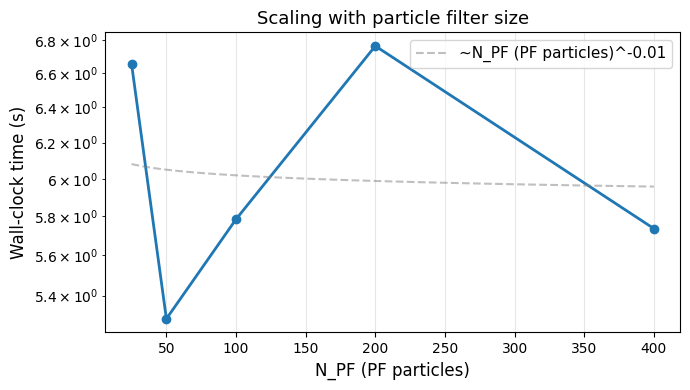

In [10]:
PF_values = [25, 50, 100, 200, 400]
times_PF = []

for npf in PF_values:
    p = make_problem(n_latent=2, T=40, n_pf=npf)
    t = bench(p, N=8, K=3, proposal="mala")
    times_PF.append(t)
    print(f"  N_PF={npf:>4d}  time={t:.2f}s")

plot_scaling(PF_values, times_PF, "N_PF (PF particles)",
             "Scaling with particle filter size");

## 6. Proposal type comparison (RW vs MALA vs Hessian)

RW needs no gradient, MALA needs one gradient, Hessian needs gradient + D forward passes.

Hess-MC²: N=2, K=1, D=13, proposal=rw, eps=0.05
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=13, proposal=rw, eps=0.05
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.0/8 [resampled]


  n_latent=1  D= 13  proposal=rw        time=5.42s


Hess-MC²: N=2, K=1, D=13, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=13, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=4.0/8 [resampled]
  step 3/3  ESS=5.1/8


  n_latent=1  D= 13  proposal=mala      time=4.98s


Hess-MC²: N=2, K=1, D=13, proposal=hessian, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=13, proposal=hessian, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=4.0/8 [resampled]
  step 3/3  ESS=5.1/8


  n_latent=1  D= 13  proposal=hessian   time=7.09s


Hess-MC²: N=2, K=1, D=24, proposal=rw, eps=0.05
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=rw, eps=0.05
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.0/8 [resampled]


  n_latent=2  D= 24  proposal=rw        time=4.65s


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=2.0/8 [resampled]
  step 3/3  ESS=2.6/8 [resampled]


  n_latent=2  D= 24  proposal=mala      time=6.32s


Hess-MC²: N=2, K=1, D=24, proposal=hessian, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=24, proposal=hessian, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=2.0/8 [resampled]
  step 3/3  ESS=2.6/8 [resampled]


  n_latent=2  D= 24  proposal=hessian   time=8.13s


Hess-MC²: N=2, K=1, D=37, proposal=rw, eps=0.05
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=37, proposal=rw, eps=0.05
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.0/8 [resampled]


  n_latent=3  D= 37  proposal=rw        time=5.50s


Hess-MC²: N=2, K=1, D=37, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=37, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.2/8 [resampled]


  n_latent=3  D= 37  proposal=mala      time=5.49s


Hess-MC²: N=2, K=1, D=37, proposal=hessian, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=37, proposal=hessian, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.2/8 [resampled]


  n_latent=3  D= 37  proposal=hessian   time=8.98s


Hess-MC²: N=2, K=1, D=52, proposal=rw, eps=0.05
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=52, proposal=rw, eps=0.05
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.0/8 [resampled]
  step 3/3  ESS=1.0/8 [resampled]


  n_latent=4  D= 52  proposal=rw        time=5.90s


Hess-MC²: N=2, K=1, D=52, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=52, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.5/8 [resampled]
  step 3/3  ESS=1.6/8 [resampled]


  n_latent=4  D= 52  proposal=mala      time=5.96s


Hess-MC²: N=2, K=1, D=52, proposal=hessian, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=3, D=52, proposal=hessian, eps=0.01
  Initializing 8 particles from prior...


  step 1/3  ESS=1.0/8 [resampled]
  step 2/3  ESS=1.5/8 [resampled]
  step 3/3  ESS=1.6/8 [resampled]


  n_latent=4  D= 52  proposal=hessian   time=10.19s


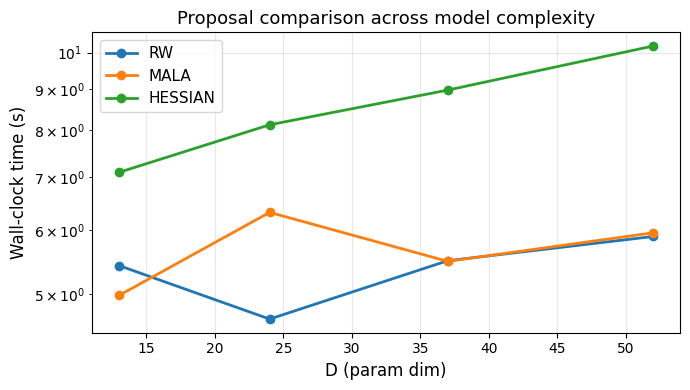

In [11]:
proposals = ["rw", "mala", "hessian"]
latent_for_prop = [1, 2, 3, 4]
times_by_prop = {pr: [] for pr in proposals}

for nl in latent_for_prop:
    p = make_problem(n_latent=nl, T=40, n_pf=50)
    for pr in proposals:
        ss = 0.01 if pr != "rw" else 0.05
        t = bench(p, N=8, K=3, proposal=pr, step_size=ss)
        times_by_prop[pr].append(t)
        print(f"  n_latent={nl}  D={p.D:>3d}  proposal={pr:<8s}  time={t:.2f}s")

dims_for_prop = []
for nl in latent_for_prop:
    p = make_problem(n_latent=nl, T=40, n_pf=50)
    dims_for_prop.append(p.D)

plot_scaling(
    dims_for_prop,
    [times_by_prop[pr] for pr in proposals],
    "D (param dim)",
    "Proposal comparison across model complexity",
    labels=[f"{pr.upper()}" for pr in proposals],
    fit_power=False,
);

## 7. Cost decomposition: init vs iteration

Measures initialization cost (sequential numpyro traces) separately from per-iteration cost.

Hess-MC²: N=2, K=1, D=13, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=1, D=13, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/1  ESS=1.0/8 [resampled]


Hess-MC²: N=2, K=1, D=13, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=10, D=13, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/10  ESS=1.0/8 [resampled]
  step 2/10  ESS=4.0/8 [resampled]
  step 3/10  ESS=5.1/8


  step 4/10  ESS=2.6/8 [resampled]
  step 5/10  ESS=2.5/8 [resampled]
  step 6/10  ESS=3.5/8 [resampled]
  step 7/10  ESS=4.2/8
  step 8/10  ESS=3.4/8 [resampled]
  step 9/10  ESS=1.7/8 [resampled]
  step 10/10  ESS=4.3/8


  L=1 D= 13  init=5.19s  per_iter=-0.01s  (K=1: 5.18s, K=10: 5.12s)


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=1, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/1  ESS=1.0/8 [resampled]


Hess-MC²: N=2, K=1, D=24, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=10, D=24, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/10  ESS=1.0/8 [resampled]
  step 2/10  ESS=2.0/8 [resampled]
  step 3/10  ESS=2.6/8 [resampled]
  step 4/10  ESS=1.4/8 [resampled]
  step 5/10  ESS=3.7/8 [resampled]
  step 6/10  ESS=3.1/8 [resampled]
  step 7/10  ESS=3.5/8 [resampled]
  step 8/10  ESS=3.9/8 [resampled]


  step 9/10  ESS=4.0/8
  step 10/10  ESS=1.8/8 [resampled]


  L=2 D= 24  init=6.80s  per_iter=-0.08s  (K=1: 6.72s, K=10: 5.98s)


Hess-MC²: N=2, K=1, D=37, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=1, D=37, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/1  ESS=1.0/8 [resampled]


Hess-MC²: N=2, K=1, D=37, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=10, D=37, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/10  ESS=1.0/8 [resampled]
  step 2/10  ESS=1.0/8 [resampled]
  step 3/10  ESS=1.2/8 [resampled]
  step 4/10  ESS=1.1/8 [resampled]
  step 5/10  ESS=1.1/8 [resampled]
  step 6/10  ESS=2.0/8 [resampled]
  step 7/10  ESS=1.0/8 [resampled]
  step 8/10  ESS=1.0/8 [resampled]
  step 9/10  ESS=1.0/8 [resampled]
  step 10/10  ESS=1.8/8 [resampled]


  L=3 D= 37  init=5.60s  per_iter=0.04s  (K=1: 5.65s, K=10: 6.04s)


Hess-MC²: N=2, K=1, D=52, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=1, D=52, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/1  ESS=1.0/8 [resampled]


Hess-MC²: N=2, K=1, D=52, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=10, D=52, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/10  ESS=1.0/8 [resampled]
  step 2/10  ESS=1.5/8 [resampled]
  step 3/10  ESS=1.6/8 [resampled]
  step 4/10  ESS=1.0/8 [resampled]
  step 5/10  ESS=1.0/8 [resampled]
  step 6/10  ESS=1.0/8 [resampled]
  step 7/10  ESS=1.0/8 [resampled]
  step 8/10  ESS=1.0/8 [resampled]
  step 9/10  ESS=1.1/8 [resampled]
  step 10/10  ESS=1.0/8 [resampled]


  L=4 D= 52  init=6.28s  per_iter=-0.01s  (K=1: 6.27s, K=10: 6.16s)


Hess-MC²: N=2, K=1, D=69, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=1, D=69, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/1  ESS=1.0/8 [resampled]


Hess-MC²: N=2, K=1, D=69, proposal=mala, eps=0.01
  Initializing 2 particles from prior...


  step 1/1  ESS=1.0/2


Hess-MC²: N=8, K=10, D=69, proposal=mala, eps=0.01
  Initializing 8 particles from prior...


  step 1/10  ESS=1.0/8 [resampled]
  step 2/10  ESS=1.0/8 [resampled]
  step 3/10  ESS=1.0/8 [resampled]
  step 4/10  ESS=1.0/8 [resampled]
  step 5/10  ESS=1.0/8 [resampled]
  step 6/10  ESS=2.4/8 [resampled]
  step 7/10  ESS=1.2/8 [resampled]
  step 8/10  ESS=1.0/8 [resampled]


  step 9/10  ESS=1.8/8 [resampled]
  step 10/10  ESS=1.0/8 [resampled]


  L=5 D= 69  init=6.60s  per_iter=0.14s  (K=1: 6.74s, K=10: 8.04s)


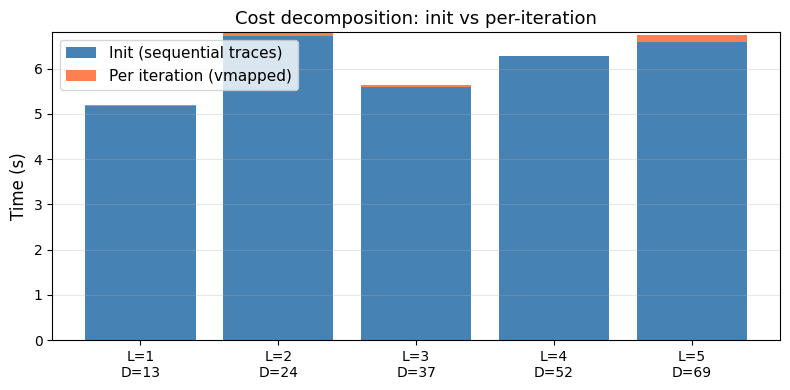

In [12]:
# Decompose: time(K=1) vs time(K=10) to separate init from per-iteration cost
decomp_latents = [1, 2, 3, 4, 5]
decomp_data = []

for nl in decomp_latents:
    p = make_problem(n_latent=nl, T=40, n_pf=50)
    t1 = bench(p, N=8, K=1, proposal="mala")
    t10 = bench(p, N=8, K=10, proposal="mala")
    # time = init + K * per_iter  →  per_iter = (t10 - t1) / 9,  init = t1 - per_iter
    per_iter = (t10 - t1) / 9
    init = t1 - per_iter
    decomp_data.append((nl, p.D, init, per_iter, t1, t10))
    print(f"  L={nl} D={p.D:>3d}  init={init:.2f}s  per_iter={per_iter:.2f}s  "
          f"(K=1: {t1:.2f}s, K=10: {t10:.2f}s)")

fig, ax = plt.subplots(figsize=(8, 4))
ds = [d[1] for d in decomp_data]
inits = [d[2] for d in decomp_data]
iters = [d[3] for d in decomp_data]
ax.bar(range(len(ds)), inits, label="Init (sequential traces)", color="steelblue")
ax.bar(range(len(ds)), iters, bottom=inits, label="Per iteration (vmapped)", color="coral")
ax.set_xticks(range(len(ds)))
ax.set_xticklabels([f"L={d[0]}\nD={d[1]}" for d in decomp_data])
ax.set_ylabel("Time (s)", fontsize=12)
ax.set_title("Cost decomposition: init vs per-iteration", fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis="y")
fig.tight_layout()

## Summary table

In [13]:
def estimate_exponent(xs, ys):
    """Fit log-log slope."""
    lx = np.log(np.array(xs, dtype=float))
    ly = np.log(np.array(ys, dtype=float))
    slope, _ = np.polyfit(lx, ly, 1)
    return slope

print("Empirical scaling exponents (time ~ x^alpha):")
print(f"  {'Dimension':<20s}  {'alpha':>8s}  {'Expected':>10s}")
print("  " + "-" * 42)
print(f"  {'D (param dim)':<20s}  {estimate_exponent(dims_lat, times_lat):>8.2f}  {'~1-2':>10s}")
print(f"  {'T (time points)':<20s}  {estimate_exponent(T_values, times_T):>8.2f}  {'~1':>10s}")
print(f"  {'N (SMC particles)':<20s}  {estimate_exponent(N_values, times_N):>8.2f}  {'~1':>10s}")
print(f"  {'K (SMC iters)':<20s}  {estimate_exponent(K_values, times_K):>8.2f}  {'~1':>10s}")
print(f"  {'N_PF (PF particles)':<20s}  {estimate_exponent(PF_values, times_PF):>8.2f}  {'~1':>10s}")

Empirical scaling exponents (time ~ x^alpha):
  Dimension                alpha    Expected
  ------------------------------------------
  D (param dim)             0.16        ~1-2
  T (time points)          -0.04          ~1
  N (SMC particles)         0.61          ~1
  K (SMC iters)             0.04          ~1
  N_PF (PF particles)      -0.01          ~1


## Cost model

Expected per-iteration cost:

$$\text{cost}(\text{iter}) = N \times \left[ c_{\text{eval}}(T, N_{PF}, n_L) + c_{\text{grad}} + \mathbb{1}[\text{hessian}] \cdot D \cdot c_{\text{grad}} \right]$$

$$\text{total} = K \times \text{cost}(\text{iter}) + \text{init}(N)$$

Where $c_{\text{eval}} \propto T \cdot N_{PF} \cdot n_L^2$ (matrix ops in PF).